# Projection of a polyhedral complex

This notebook describes how to compute the image of a polyhedral complex under a linear projection. In general this is a bad idea for several reasons:
- There is no canonical structure of a polyhedral complex of the image
- Refining to get the structure of a polyhedral complex results in an enormous amount of convex hull operations.
- This refinement probably does not give the best structure.

If you are presented with this question, you should instead ask what is special about your problem, instead of solving this general question.

You have been warned.

We start by loading Oscar.

In [1]:
using Oscar


You've found 
DORY
Version 0.1 ... 
 ... which comes with absolutely no warranty whatsoever
(c) 2019 by Avinash Kulkarni


You've found 
DORY
Version 0.1 ... 
 ... which comes with absolutely no warranty whatsoever
(c) 2019 by Avinash Kulkarni

 -----    -----    -----      -      -----   
|     |  |     |  |     |    | |    |     |  
|     |  |        |         |   |   |     |  
|     |   -----   |        |     |  |-----   
|     |        |  |        |-----|  |   |    
|     |  |     |  |     |  |     |  |    |   
 -----    -----    -----   -     -  -     -  

...combining (and extending) ANTIC, GAP, Polymake and Singular
Version 0.8.2-DEV ... 
 ... which comes with absolutely no warranty whatsoever
Type: '?Oscar' for more information
(c) 2019-2022 by The Oscar Development Team


┌ Info: Precompiling Oscar [f1435218-dba5-11e9-1e4d-f1a5fab5fc13]
└ @ Base loading.jl:1423
polymake:  WARNING: Recompiling in /home/lars/.julia/scratchspaces/d720cf60-89b5-51f5-aff5-213f193123e7/polymake_18301592892584958984_1.7_userdir/wrappers.0/build/Opt, please be patient...
┌ Warning: Replacing docs for `Oscar.F :: Union{Tuple{Hecke.SRow{T}}, Tuple{T}} where T` in module `Oscar`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Oscar.F :: Union{Tuple{Vector{T}}, Tuple{T}} where T` in module `Oscar`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Package Oscar does not have pAdicSolver in its dependencies:
│ - If you have Oscar checked out for development and have
│   added pAdicSolver as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Oscar
└ Loading pAdicSolver into Oscar from project dependency, future warnings for Oscar are suppressed.
  ** incremental compilation may be

Next we make a polyhedral complex. It will consist of two 2-dimensional squares embedded at different heights in 3-space. The projection will just be eliminating the height.

In [19]:
ht = 1
c1 = convex_hull([0 0 ht; 2 0 ht; 2 2 ht; 0 2 ht])
ht = 2
c2 = convex_hull([1 1 ht; 3 1 ht; 3 3 ht; 1 3 ht])

A polyhedron in ambient dimension 3

We will use polymake's method `check_fan_objects` for creating the polyhedral complex. This is computationally expensive, but what we are about to do is worse anyway.

In [20]:
PF = Polymake.fan.check_fan_objects(c1.pm_polytope, c2.pm_polytope)
PC = PolyhedralComplex(Polymake.fan.PolyhedralComplex(PF))

A polyhedral complex in ambient dimension 3

In [21]:
vertices_and_rays(PC)

8-element SubObjectIterator{Union{PointVector{Polymake.Rational}, RayVector{Polymake.Rational}}}:
 [0, 0, 1]
 [2, 0, 1]
 [2, 2, 1]
 [0, 2, 1]
 [1, 1, 2]
 [3, 1, 2]
 [3, 3, 2]
 [1, 3, 2]

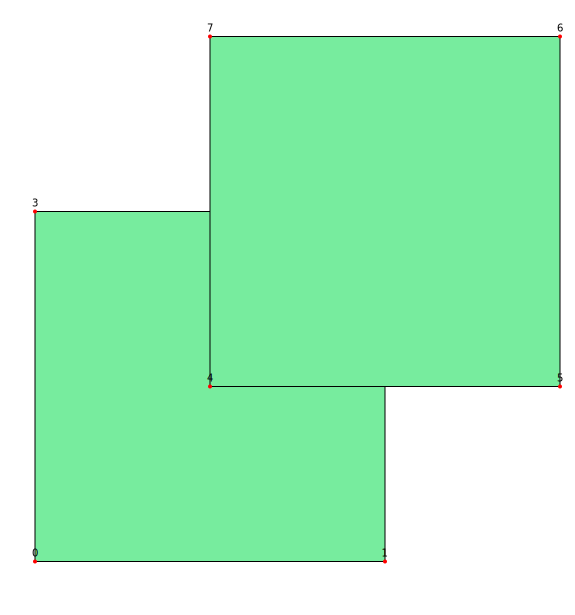

In [22]:
Polymake.visual(PC.pm_complex)

In [33]:
projection = matrix(QQ, [1 0 0; 0 1 0])

[1   0   0]
[0   1   0]

The first step is to project all the polyhedra. Since Oscar is row-based we will transpose the projection.

In [52]:
projected_polyhedra = []
for p in maximal_polyhedra(PC)
    vp = matrix(QQ, vertices(p)) * transpose(projection)
    rp = matrix(QQ, rays(p)) * transpose(projection)
    lp = matrix(QQ, lineality_space(p)) * transpose(projection)
    projected_p = convex_hull(vp, rp, lp)
    push!(projected_polyhedra, projected_p)
end
projected_polyhedra

2-element Vector{Any}:
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2

As a next step we collect all facets and then we slice all polyhedra along these facets. We will not optimize this to omit the facets of the polyhedron we are slicing, since this only reduces the overhead minimally.

In [69]:
Fp = reduce(vcat, [collect(facets(Polyhedron, p)) for p in projected_polyhedra])
F = reduce(vcat, [collect(facets(p)) for p in projected_polyhedra])

8-element Vector{AffineHalfspace}:
 The Halfspace of R^2 described by
1: -x₁ ≦ 0

 The Halfspace of R^2 described by
1: -x₂ ≦ 0

 The Halfspace of R^2 described by
1: x₁ ≦ 2

 The Halfspace of R^2 described by
1: x₂ ≦ 2

 The Halfspace of R^2 described by
1: -x₁ ≦ -1

 The Halfspace of R^2 described by
1: -x₂ ≦ -1

 The Halfspace of R^2 described by
1: x₁ ≦ 3

 The Halfspace of R^2 described by
1: x₂ ≦ 3


For every facet we will generate the positive and negative half-space. Storing these will avoid some computational overhead.

In [102]:
Fpairs = []
for facet in F
    normal = permutedims(hcat([[x for x in facet.a]]...))
    positive = Polyhedron(normal, [facet.b])
    negative = Polyhedron(-normal, [-facet.b])
    push!(Fpairs, [positive, negative])
end
Fpairs

8-element Vector{Any}:
 Polyhedron[A polyhedron in ambient dimension 2, A polyhedron in ambient dimension 2]
 Polyhedron[A polyhedron in ambient dimension 2, A polyhedron in ambient dimension 2]
 Polyhedron[A polyhedron in ambient dimension 2, A polyhedron in ambient dimension 2]
 Polyhedron[A polyhedron in ambient dimension 2, A polyhedron in ambient dimension 2]
 Polyhedron[A polyhedron in ambient dimension 2, A polyhedron in ambient dimension 2]
 Polyhedron[A polyhedron in ambient dimension 2, A polyhedron in ambient dimension 2]
 Polyhedron[A polyhedron in ambient dimension 2, A polyhedron in ambient dimension 2]
 Polyhedron[A polyhedron in ambient dimension 2, A polyhedron in ambient dimension 2]

Now for every projected polyhedron we will subdivide it along the fpairs. We will only collect those that are non-empty.

In [103]:
collected = []
for p in projected_polyhedra
    pieces = [p]
    for pair in Fpairs
        newpieces = []
        for pp in pieces
            pos = intersect(pp, pair[1])
            neg = intersect(pp, pair[2])
            if isfeasible(pos)
                push!(newpieces, pos)
            end
            if isfeasible(neg)
                push!(newpieces, neg)
            end
        end
        pieces = newpieces
    end
    append!(collected, pieces)
end
collected

32-element Vector{Any}:
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 ⋮
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2
 A polyhedron in ambient dimension 2

In [104]:
for p in collected
    println(vertices(p))
end

PointVector{Polymake.Rational}[[2, 1], [2, 2], [1, 2], [1, 1]]
PointVector{Polymake.Rational}[[2, 0], [2, 1], [1, 1], [1, 0]]
PointVector{Polymake.Rational}[[1, 1], [1, 2], [0, 2], [0, 1]]
PointVector{Polymake.Rational}[[1, 0], [1, 1], [0, 1], [0, 0]]
PointVector{Polymake.Rational}[[2, 2], [1, 2]]
PointVector{Polymake.Rational}[[1, 2], [0, 2]]
PointVector{Polymake.Rational}[[2, 1], [2, 2]]
PointVector{Polymake.Rational}[[2, 0], [2, 1]]
PointVector{Polymake.Rational}[[2, 2]]
PointVector{Polymake.Rational}[[2, 0], [1, 0]]
PointVector{Polymake.Rational}[[1, 0], [0, 0]]
PointVector{Polymake.Rational}[[2, 0]]
PointVector{Polymake.Rational}[[0, 1], [0, 2]]
PointVector{Polymake.Rational}[[0, 0], [0, 1]]
PointVector{Polymake.Rational}[[0, 2]]
PointVector{Polymake.Rational}[[0, 0]]
PointVector{Polymake.Rational}[[2, 1], [2, 2], [1, 2], [1, 1]]
PointVector{Polymake.Rational}[[2, 1], [1, 1]]
PointVector{Polymake.Rational}[[1, 1], [1, 2]]
PointVector{Polymake.Rational}[[1, 1]]
PointVector{Polymake

In [106]:
projected_PF = Polymake.fan.check_fan_objects([x.pm_polytope for x in collected]...)
projected_PC = PolyhedralComplex(Polymake.fan.PolyhedralComplex(projected_PF))

A polyhedral complex in ambient dimension 2

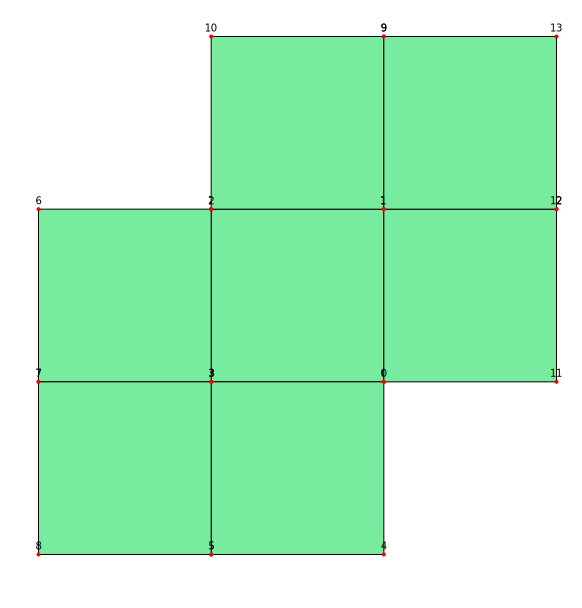

In [107]:
Polymake.visual(projected_PC.pm_complex)

# As one function

In [108]:
function project_polyhedral_complex(PC::PolyhedralComplex, projection)
    # 1. Project the maximal polyhedra
    projected_polyhedra = []
    for p in maximal_polyhedra(PC)
        vp = matrix(QQ, vertices(p)) * transpose(projection)
        rp = matrix(QQ, rays(p)) * transpose(projection)
        lp = matrix(QQ, lineality_space(p)) * transpose(projection)
        projected_p = convex_hull(vp, rp, lp)
        push!(projected_polyhedra, projected_p)
    end
    
    # 2. Build all halfspace pairs
    F = reduce(vcat, [collect(facets(p)) for p in projected_polyhedra])
    Fpairs = []
    for facet in F
        normal = permutedims(hcat([[x for x in facet.a]]...))
        positive = Polyhedron(normal, [facet.b])
        negative = Polyhedron(-normal, [-facet.b])
        push!(Fpairs, [positive, negative])
    end
    
    # 3. Intersect like crazy
    collected = []
    for p in projected_polyhedra
        pieces = [p]
        for pair in Fpairs
            newpieces = []
            for pp in pieces
                pos = intersect(pp, pair[1])
                neg = intersect(pp, pair[2])
                if isfeasible(pos)
                    push!(newpieces, pos)
                end
                if isfeasible(neg)
                    push!(newpieces, neg)
                end
            end
            pieces = newpieces
        end
        append!(collected, pieces)
    end
    
    # 4. Final conversion
    projected_PF = Polymake.fan.check_fan_objects([x.pm_polytope for x in collected]...)
    projected_PC = PolyhedralComplex(Polymake.fan.PolyhedralComplex(projected_PF))
    return projected_PC
end

project_polyhedral_complex (generic function with 1 method)

In [109]:
PP = project_polyhedral_complex(PC, projection)

A polyhedral complex in ambient dimension 2

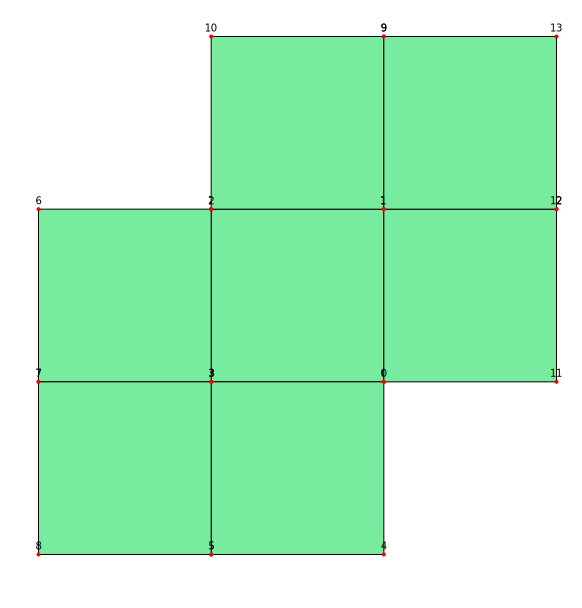

In [110]:
visualize(PP)